# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)
    train_feats = [var for x in train_feats for var in train_feats[x]]

In [7]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"), rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


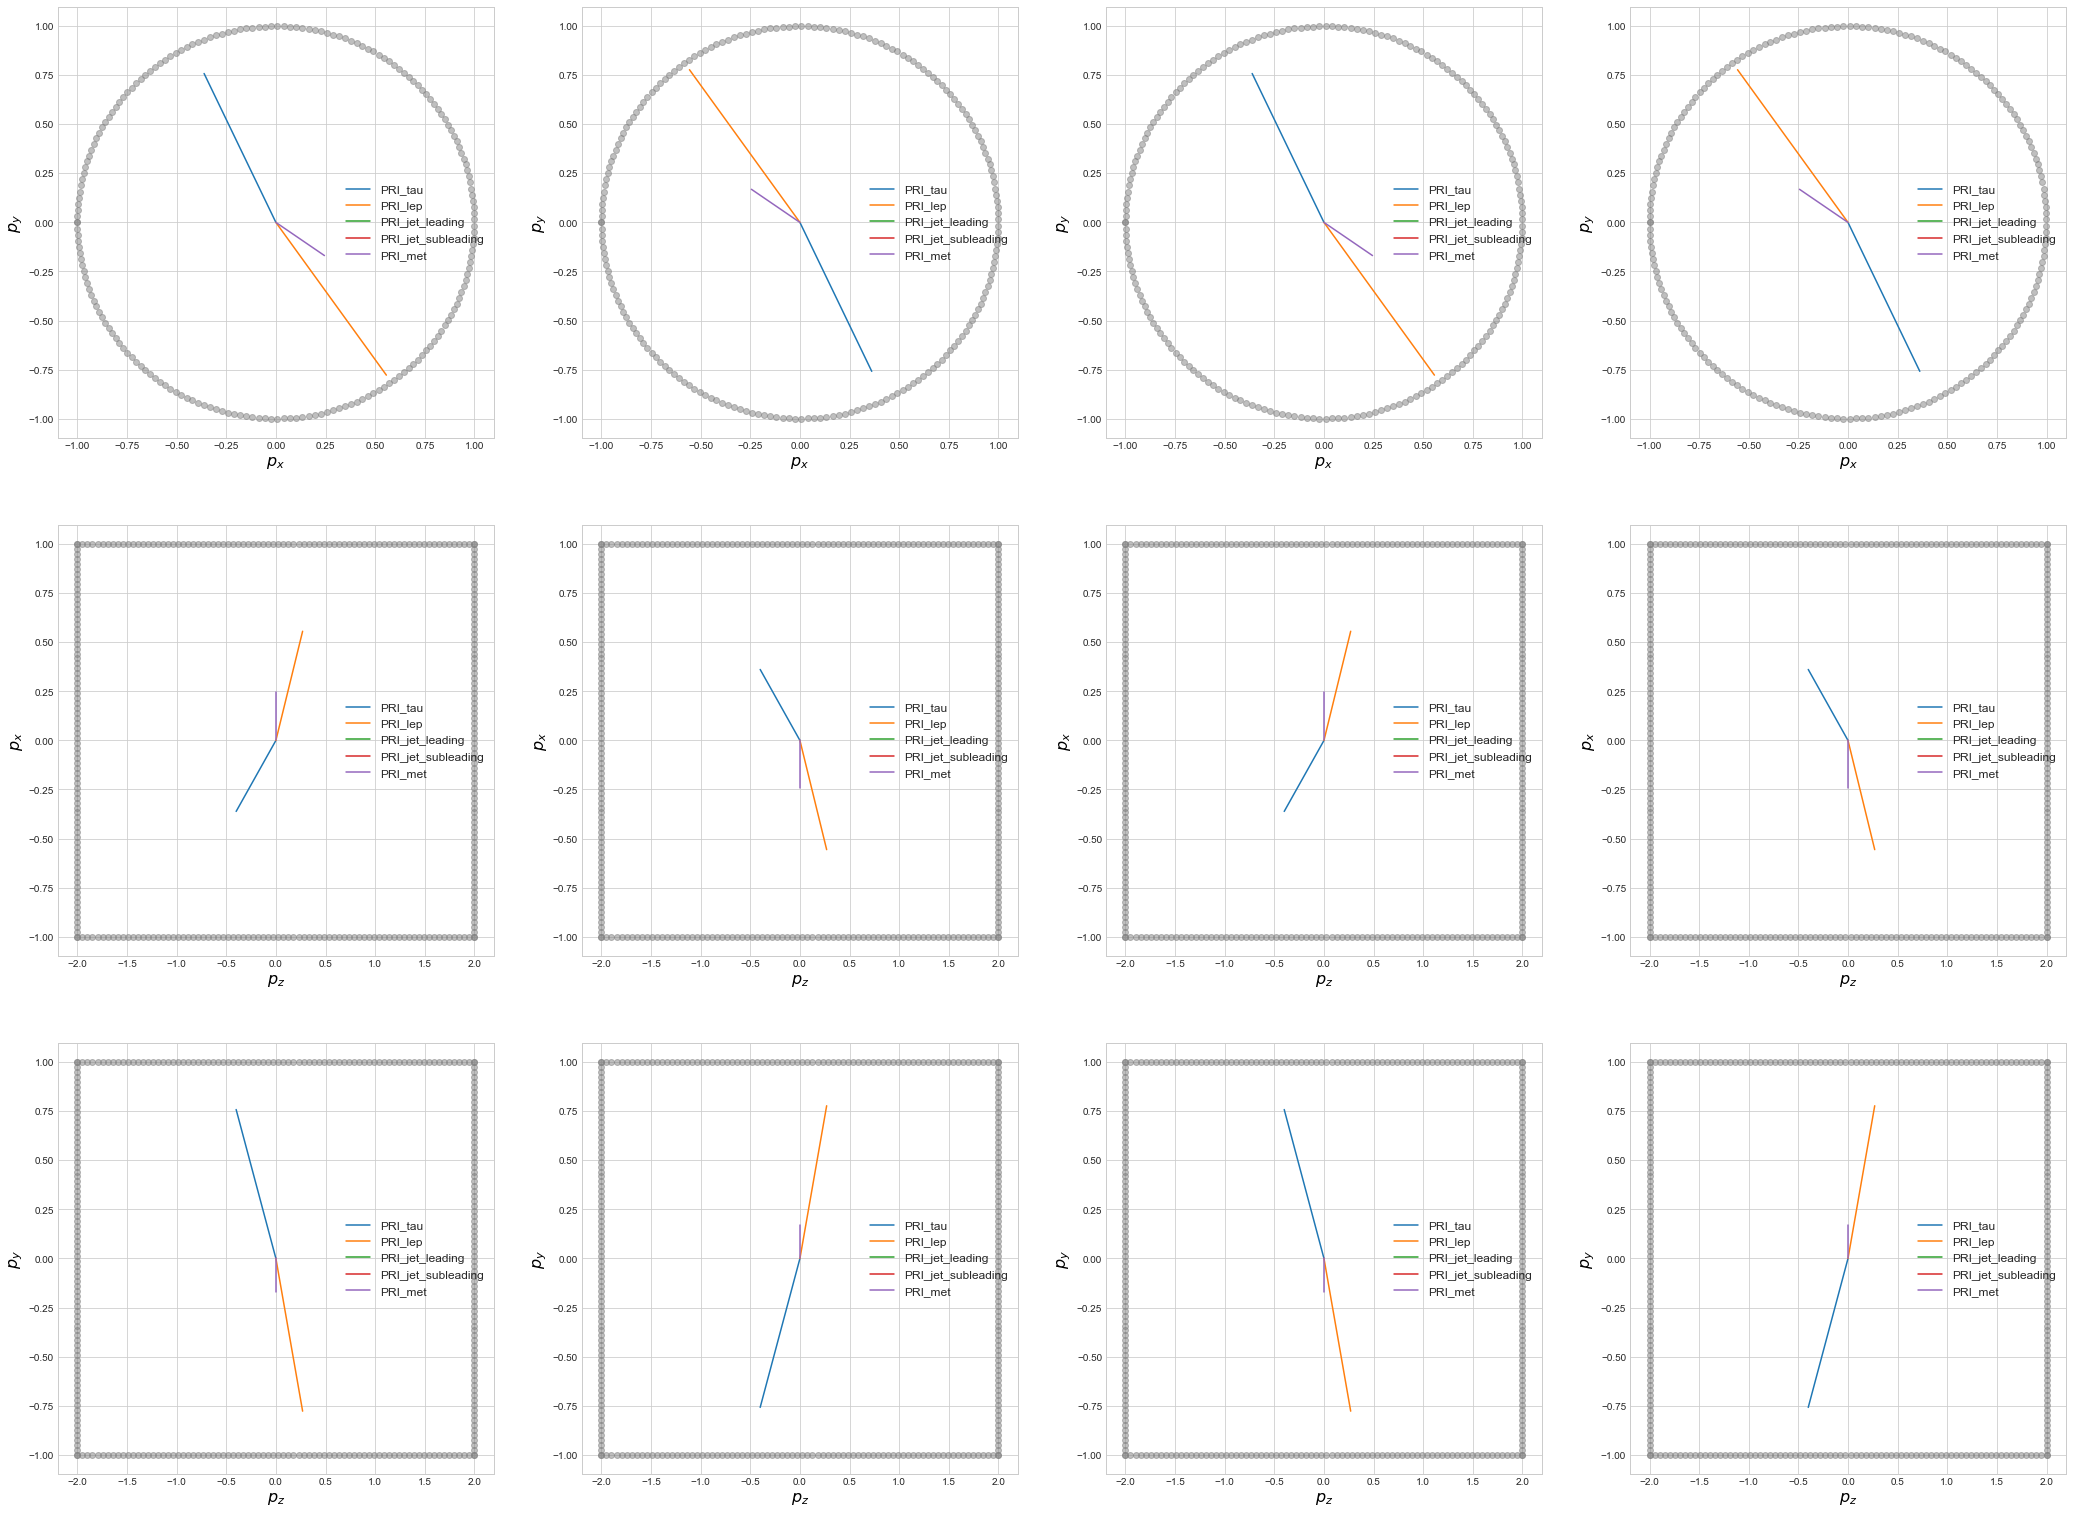

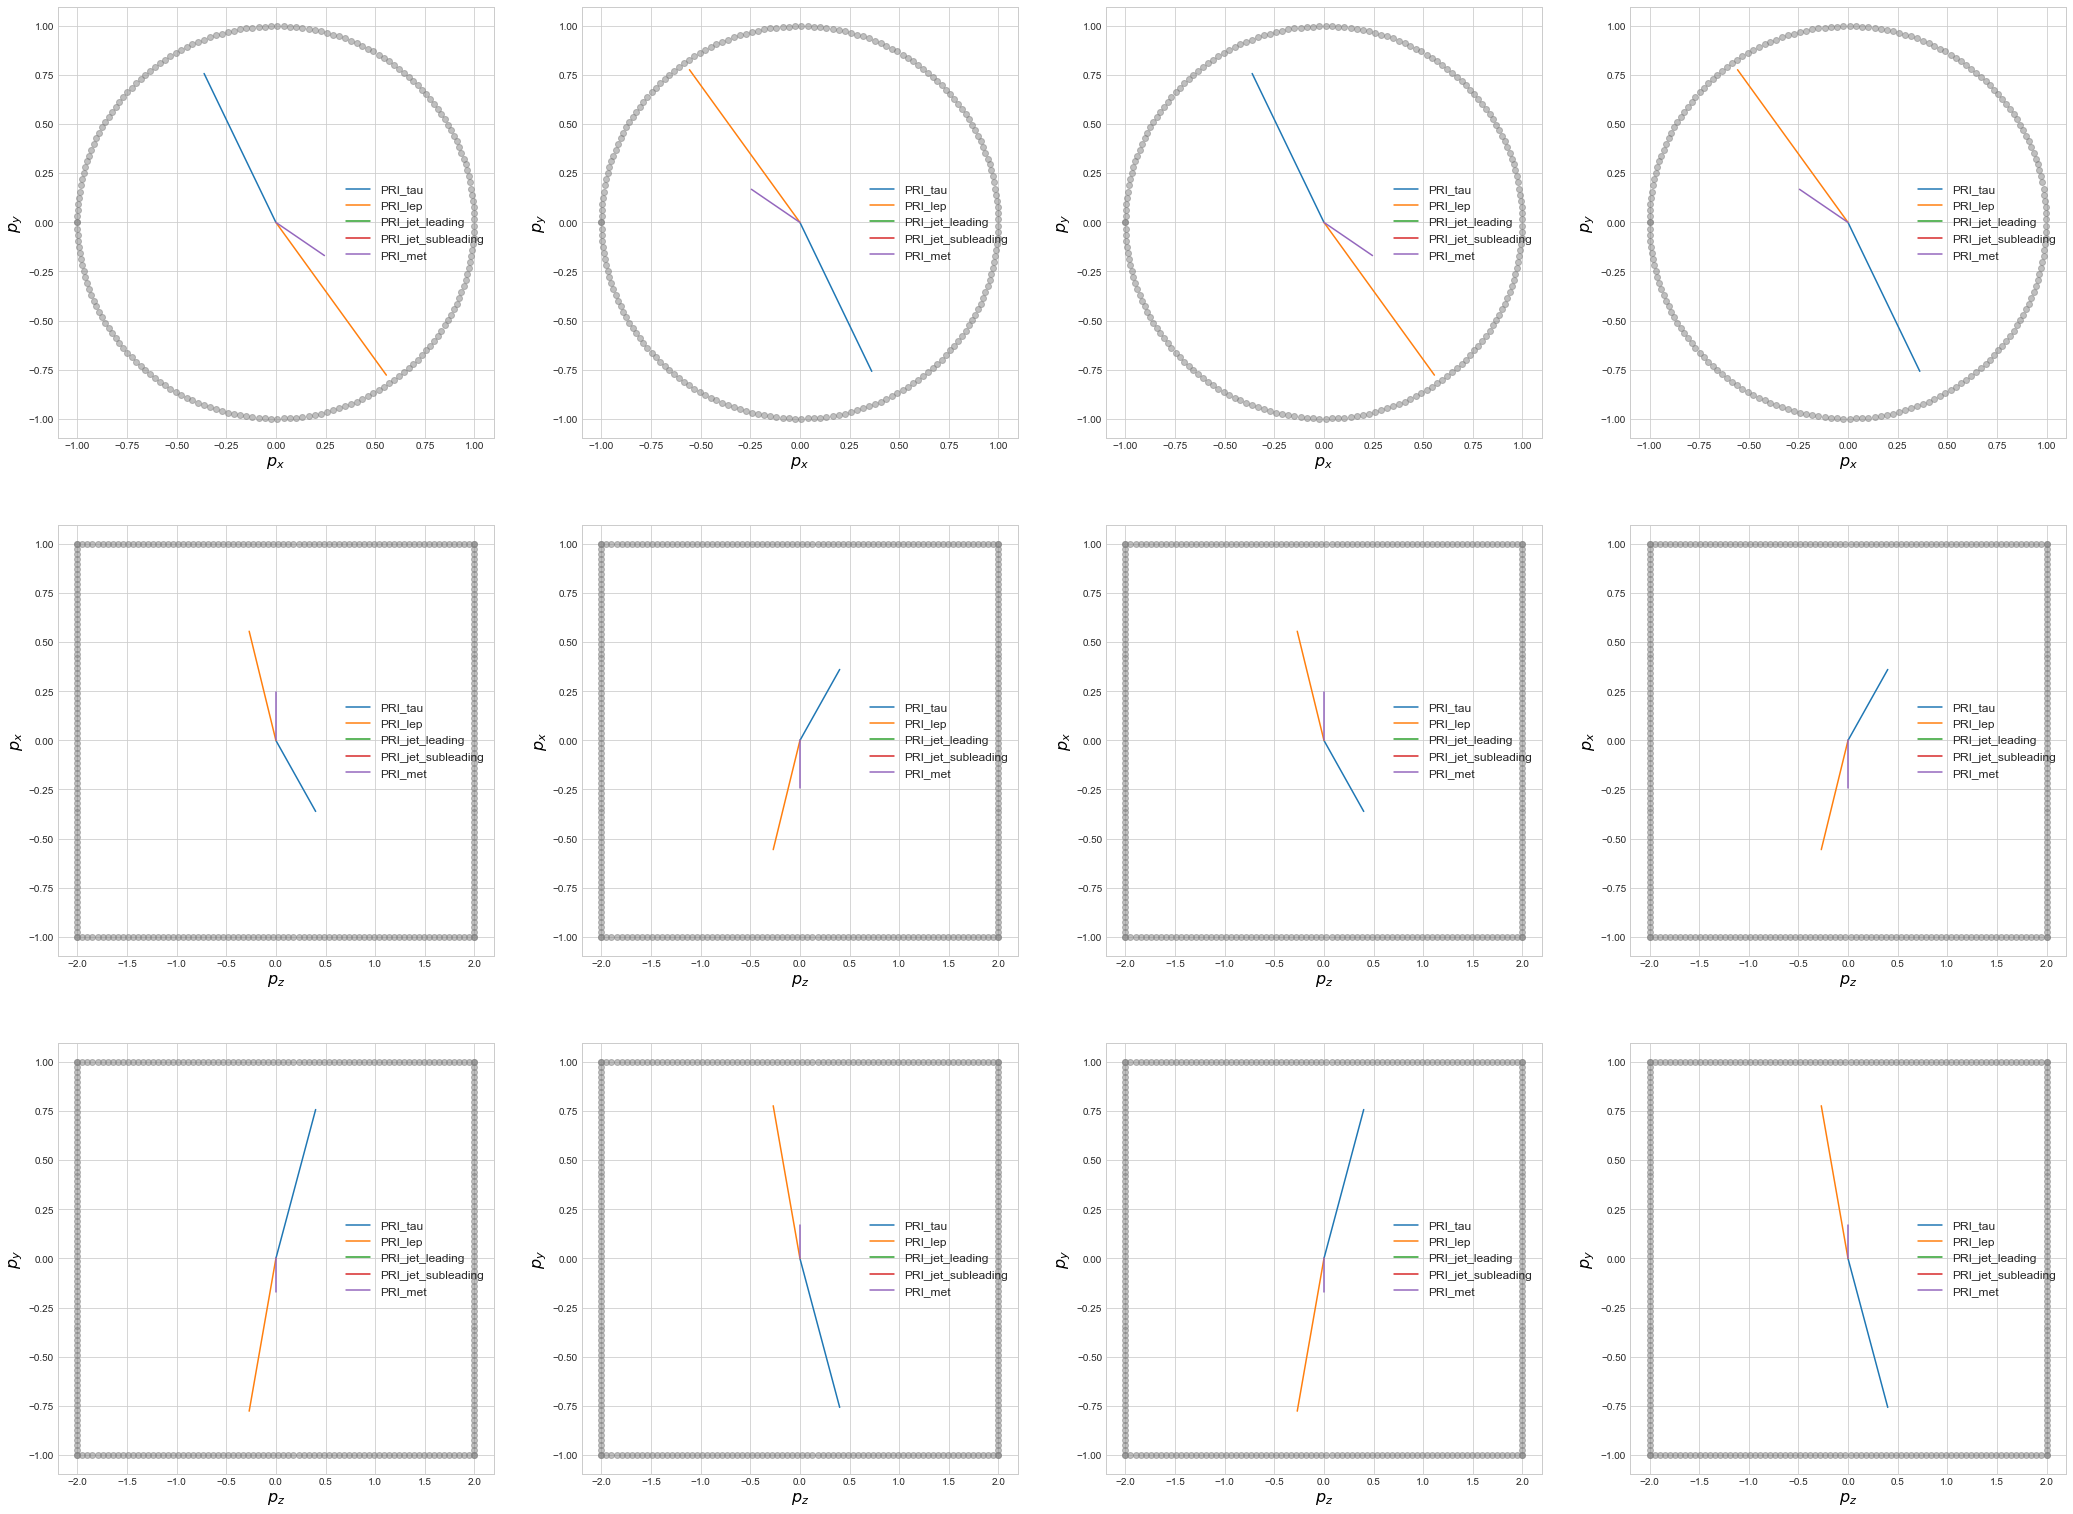

In [5]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode



/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 11.390s 


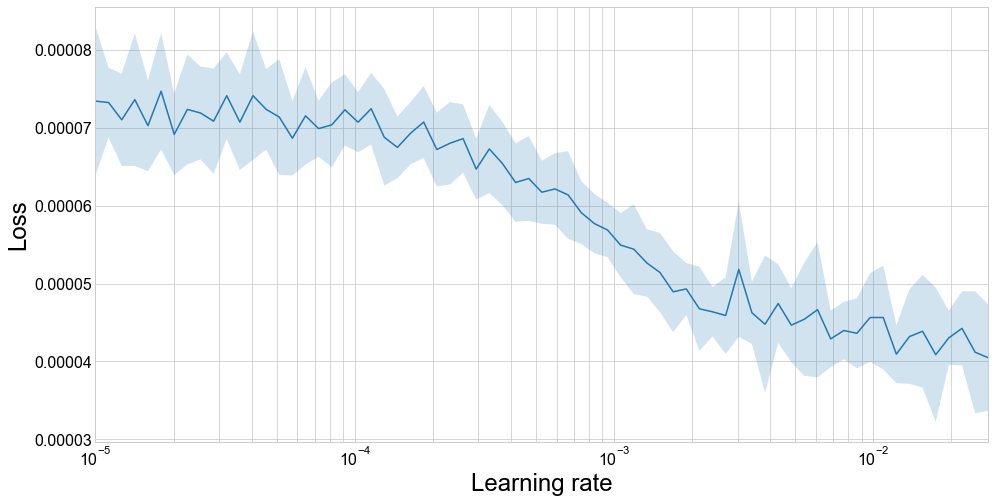

______________________________________



In [6]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [8]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':1, 'reverse':False, 'redux_decay':True, 'scale':25}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode

1 New best found: 3.9194143941535995e-05
2 New best found: 3.7763591936606947e-05
3 New best found: 3.670718176605648e-05
4 New best found: 3.626929940963659e-05
5 New best found: 3.621240854043845e-05
6 New best found: 3.588479765788701e-05
7 New best found: 3.554393834733629e-05
8 New best found: 3.544933988278453e-05
9 New best found: 3.529906492300847e-05
11 New best found: 3.487683230602395e-05
14 New best found: 3.463387989099123e-05
16 New best found: 3.441906706006195e-05
18 New best found: 3.4314731073996205e-05
22 New best found: 3.4265779759901726e-05
24 New best found: 3.425726398500786e-05
Saving snapshot 1
25 New best found: 3.425482595108903e-05
41 New best found: 3.416947759422192e-05
42 New best found: 3.403338899482003e-05
43 New best found: 3.402519288573716e-05
44 New best found: 3.389943916398416e-05
46 New best found: 3.387556784409789e-05
47 New best fo

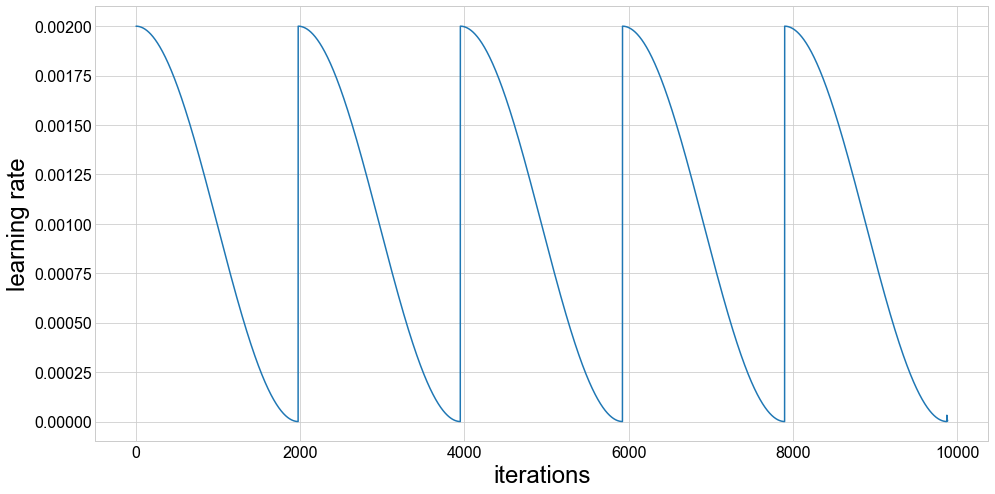

Fold took 60.247s

Training model 2 / 10
Using cosine LR annealing
1 New best found: 3.8886879943311216e-05
2 New best found: 3.7098275710013694e-05
3 New best found: 3.5791187210270435e-05
4 New best found: 3.5618884054565566e-05
6 New best found: 3.484086432144977e-05
8 New best found: 3.469168438168708e-05
9 New best found: 3.423596435750369e-05
10 New best found: 3.421945652371505e-05
13 New best found: 3.369326650135917e-05
14 New best found: 3.3657728844264055e-05
16 New best found: 3.3620734946453014e-05
17 New best found: 3.3487531302671414e-05
18 New best found: 3.3433954522479324e-05
19 New best found: 3.340580391814001e-05
20 New best found: 3.3330424886662516e-05
21 New best found: 3.327405676827766e-05
22 New best found: 3.324971698311856e-05
23 New best found: 3.3238632004940884e-05
Saving snapshot 1
25 New best found: 3.32353088502714e-05
40 New best found: 3.322757556816214e-05
41 New best found: 3.3209863092633896e-05
42 New best found: 3.3180478154827145e-05
44 New be

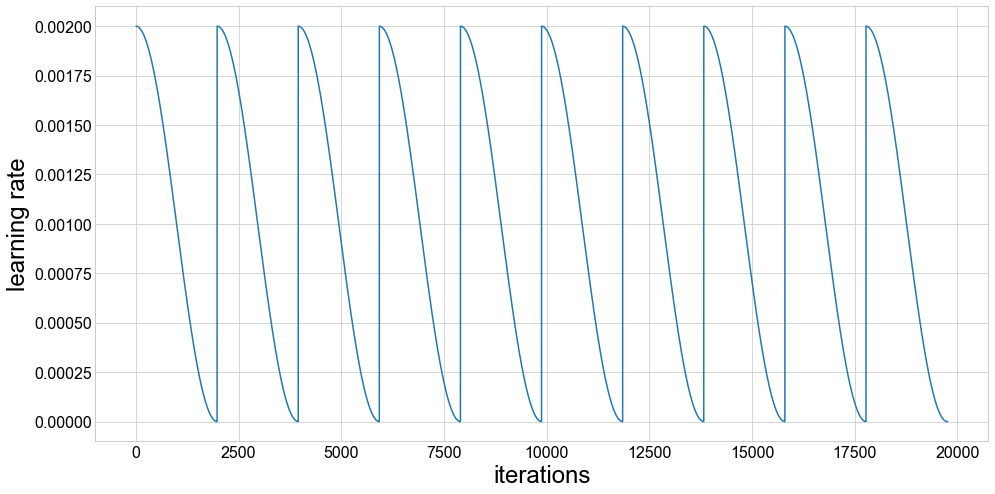

Fold took 117.861s

Training model 3 / 10
Using cosine LR annealing
1 New best found: 3.9120818568021435e-05
2 New best found: 3.6648482772082014e-05
3 New best found: 3.613062482474499e-05
4 New best found: 3.554564053951754e-05
5 New best found: 3.5525628141625665e-05
6 New best found: 3.4772072399213135e-05
7 New best found: 3.4431169394708495e-05
8 New best found: 3.417205093395083e-05
9 New best found: 3.403562994778275e-05
10 New best found: 3.3989461983473e-05
11 New best found: 3.390823663751415e-05
12 New best found: 3.390518735066125e-05
13 New best found: 3.357232381782027e-05
14 New best found: 3.3444026222277395e-05
16 New best found: 3.3086964967198616e-05
21 New best found: 3.301847196762038e-05
22 New best found: 3.2923116258807604e-05
23 New best found: 3.289430905765373e-05
24 New best found: 3.2874463914784826e-05
Saving snapshot 1
38 New best found: 3.2873559266151485e-05
40 New best found: 3.2866205205861675e-05
41 New best found: 3.2764279145992684e-05
44 New best

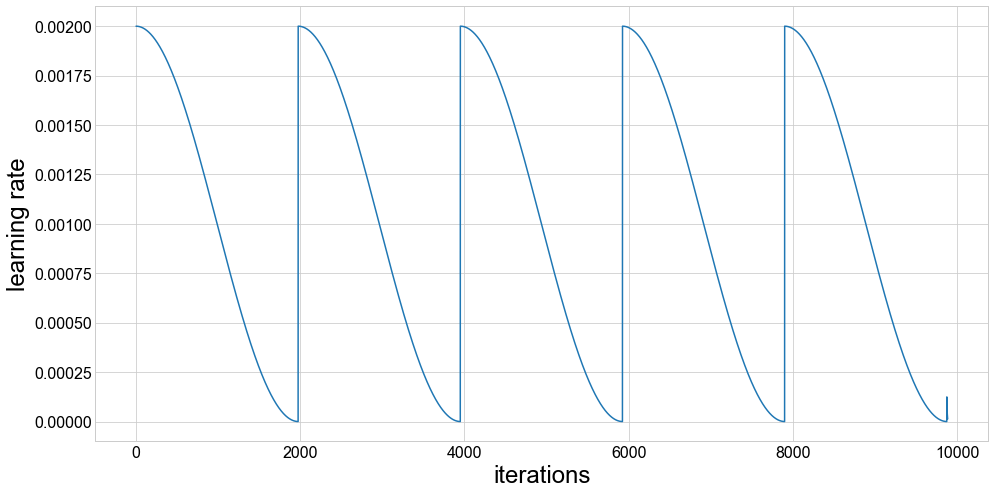

Fold took 63.535s

Training model 4 / 10
Using cosine LR annealing
1 New best found: 3.8925664475787474e-05
2 New best found: 3.681489624671024e-05
3 New best found: 3.5512506408928316e-05
4 New best found: 3.482777398933062e-05
5 New best found: 3.4092190960353824e-05
8 New best found: 3.3975889853807453e-05
9 New best found: 3.3805192426377837e-05
10 New best found: 3.364078839918022e-05
11 New best found: 3.356444797658833e-05
12 New best found: 3.32579162034827e-05
13 New best found: 3.32289784786197e-05
14 New best found: 3.297507411968678e-05
15 New best found: 3.2808675118521236e-05
16 New best found: 3.280028042030228e-05
18 New best found: 3.266410578049165e-05
20 New best found: 3.256662787034752e-05
22 New best found: 3.249160123097492e-05
23 New best found: 3.2456415348727744e-05
24 New best found: 3.245338375640135e-05
Saving snapshot 1
25 New best found: 3.245234457723251e-05
40 New best found: 3.241682458108528e-05
43 New best found: 3.2346791185456355e-05
44 New best fo

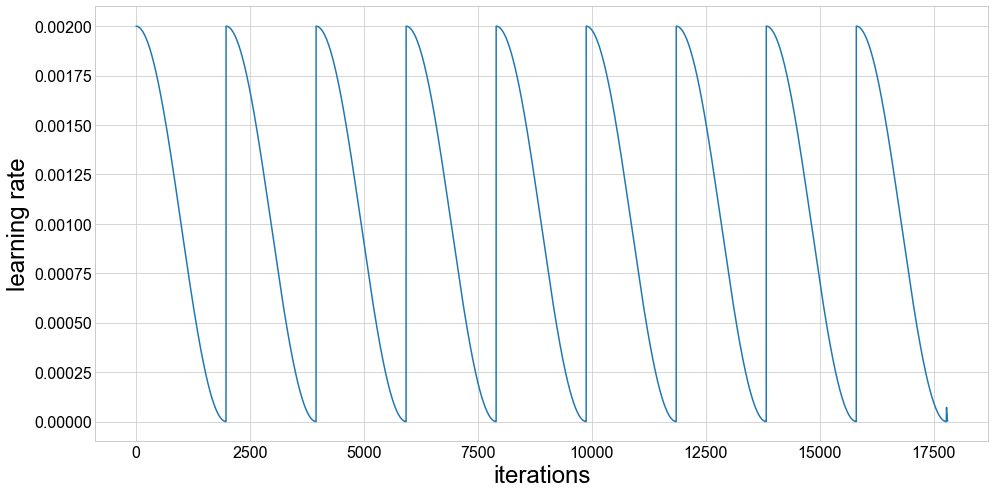

Fold took 121.296s

Training model 5 / 10
Using cosine LR annealing
1 New best found: 3.783853570657754e-05
2 New best found: 3.616583177102077e-05
3 New best found: 3.481037355534187e-05
5 New best found: 3.4050387178132614e-05
7 New best found: 3.341790009106835e-05
8 New best found: 3.3065101479385255e-05
11 New best found: 3.298852923223758e-05
12 New best found: 3.2788544650434276e-05
14 New best found: 3.274647981139976e-05
15 New best found: 3.228692852778029e-05
16 New best found: 3.2273844385925954e-05
20 New best found: 3.221785063830788e-05
22 New best found: 3.2128270585194e-05
23 New best found: 3.211237375236743e-05
24 New best found: 3.2094563160325524e-05
Saving snapshot 1
25 New best found: 3.2093047291012556e-05
41 New best found: 3.194434289527885e-05
42 New best found: 3.1769635210335944e-05
43 New best found: 3.176481894132758e-05
47 New best found: 3.171422343427511e-05
Saving snapshot 2
68 New best found: 3.167924313803221e-05
69 New best found: 3.164743197246220

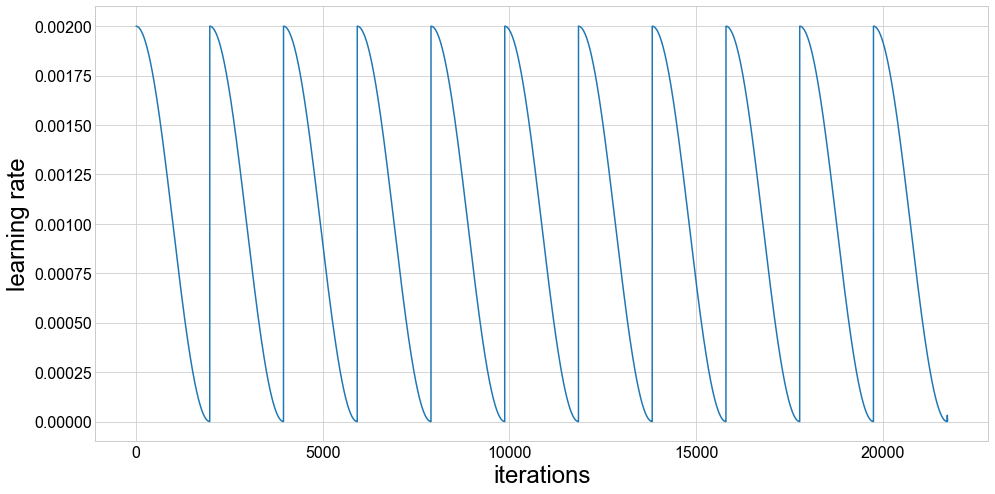

Fold took 139.921s

Training model 6 / 10
Using cosine LR annealing
1 New best found: 3.7758029022370465e-05
2 New best found: 3.572659945493797e-05
3 New best found: 3.535636491578771e-05
4 New best found: 3.503931083687348e-05
5 New best found: 3.468780046969187e-05
6 New best found: 3.40172594980686e-05
7 New best found: 3.392395541304723e-05
8 New best found: 3.355486233631382e-05
9 New best found: 3.3486970463127364e-05
10 New best found: 3.3155496563995255e-05
14 New best found: 3.287900805735262e-05
16 New best found: 3.26919642437133e-05
17 New best found: 3.260206734703388e-05
18 New best found: 3.2377668922708835e-05
19 New best found: 3.236953660525614e-05
20 New best found: 3.232103878617636e-05
21 New best found: 3.227640500481357e-05
23 New best found: 3.226055877748877e-05
24 New best found: 3.222973149822792e-05
Saving snapshot 1
25 New best found: 3.222779807983898e-05
39 New best found: 3.216679856413975e-05
41 New best found: 3.2123996724840254e-05
42 New best found:

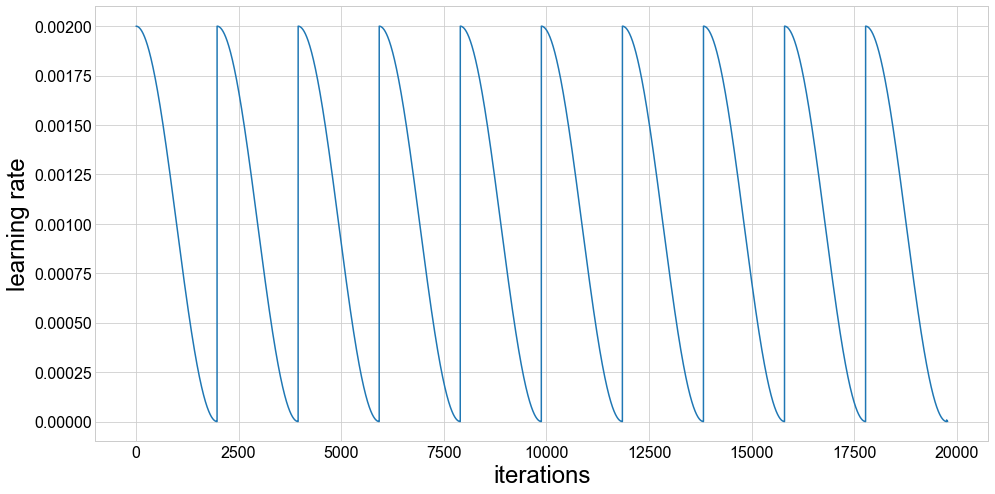

Fold took 137.514s

Training model 7 / 10
Using cosine LR annealing
1 New best found: 3.7407027673907575e-05
2 New best found: 3.527822325268062e-05
3 New best found: 3.4158223040867595e-05
4 New best found: 3.381083295826102e-05
6 New best found: 3.2926882535684855e-05
7 New best found: 3.265932133363094e-05
10 New best found: 3.249063685507281e-05
12 New best found: 3.2167201647826006e-05
14 New best found: 3.1995145604014395e-05
15 New best found: 3.186996761505725e-05
16 New best found: 3.1737453963432923e-05
18 New best found: 3.162510858674068e-05
20 New best found: 3.15479621043778e-05
21 New best found: 3.148912754404591e-05
23 New best found: 3.1474383058957754e-05
24 New best found: 3.146459351846716e-05
Saving snapshot 1
25 New best found: 3.146283658425091e-05
43 New best found: 3.1194700997730254e-05
44 New best found: 3.118216424772982e-05
47 New best found: 3.1180642846447884e-05
Saving snapshot 2
69 New best found: 3.113910679676337e-05
70 New best found: 3.107344159507

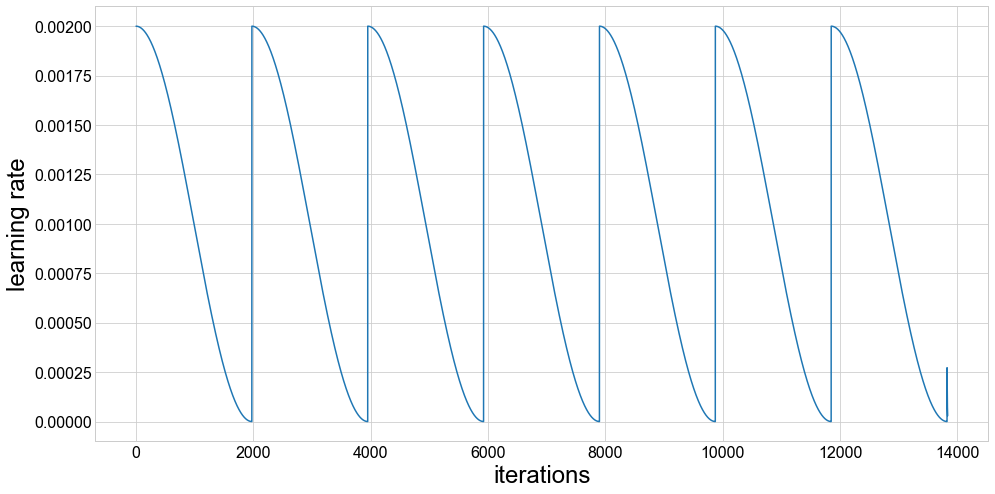

Fold took 97.321s

Training model 8 / 10
Using cosine LR annealing
1 New best found: 3.719737944154104e-05
2 New best found: 3.641463827820152e-05
3 New best found: 3.540742025419244e-05
4 New best found: 3.535657856454008e-05
6 New best found: 3.4657738347036455e-05
7 New best found: 3.39937768402293e-05
12 New best found: 3.342660907395139e-05
14 New best found: 3.324213913467653e-05
16 New best found: 3.305226607822636e-05
17 New best found: 3.290665369771105e-05
21 New best found: 3.27820645577429e-05
22 New best found: 3.277724386817865e-05
23 New best found: 3.2767415492328565e-05
24 New best found: 3.2754523453722884e-05
Saving snapshot 1
25 New best found: 3.27531550988225e-05
42 New best found: 3.2717905289823525e-05
43 New best found: 3.269243480466648e-05
45 New best found: 3.265887136618325e-05
47 New best found: 3.2643595012391936e-05
48 New best found: 3.262128995485826e-05
49 New best found: 3.2611937719697054e-05
Saving snapshot 2
50 New best found: 3.261029277382068e-0

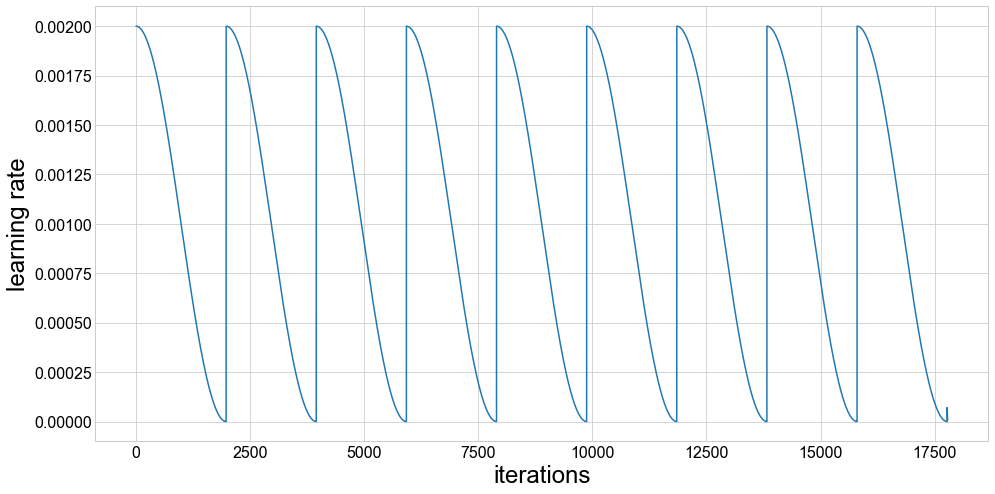

Fold took 126.017s

Training model 9 / 10
Using cosine LR annealing
1 New best found: 3.7272663695330266e-05
2 New best found: 3.601352775003761e-05
3 New best found: 3.518442309286911e-05
4 New best found: 3.4643751787371004e-05
5 New best found: 3.437061367440038e-05
6 New best found: 3.4325776479090566e-05
7 New best found: 3.4238511345756705e-05
8 New best found: 3.3935705083422365e-05
9 New best found: 3.360299225751078e-05
10 New best found: 3.349987254186999e-05
11 New best found: 3.309859076252906e-05
13 New best found: 3.290177188173402e-05
18 New best found: 3.286786718526855e-05
19 New best found: 3.274108086479828e-05
21 New best found: 3.2698544445156586e-05
22 New best found: 3.2615190044452904e-05
24 New best found: 3.2611594039190095e-05
Saving snapshot 1
25 New best found: 3.2610724949336145e-05
36 New best found: 3.258099527156446e-05
37 New best found: 3.247167303634342e-05
43 New best found: 3.244841119594639e-05
44 New best found: 3.239887890958926e-05
45 New best 

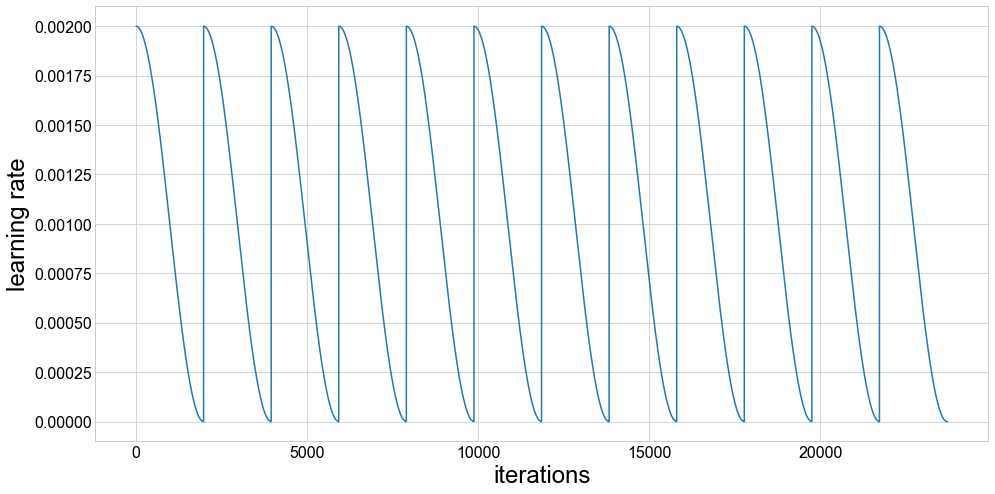

Fold took 171.336s

Training model 10 / 10
Using cosine LR annealing
1 New best found: 3.717296660929723e-05
2 New best found: 3.58792464247308e-05
4 New best found: 3.501906208357262e-05
5 New best found: 3.4117673595157183e-05
7 New best found: 3.402547603684721e-05
9 New best found: 3.401905054423147e-05
10 New best found: 3.3477137608955025e-05
12 New best found: 3.327410686831197e-05
13 New best found: 3.322895654874193e-05
14 New best found: 3.296643815765859e-05
15 New best found: 3.2822313333561434e-05
16 New best found: 3.2783084371224526e-05
17 New best found: 3.2707995145437216e-05
18 New best found: 3.2697023934361345e-05
19 New best found: 3.258857327651868e-05
20 New best found: 3.258588775145127e-05
21 New best found: 3.2545942003237974e-05
23 New best found: 3.253553416771562e-05
24 New best found: 3.25222018756505e-05
Saving snapshot 1
25 New best found: 3.2517811128648e-05
40 New best found: 3.248459043756655e-05
41 New best found: 3.227392914488377e-05
45 New best fo

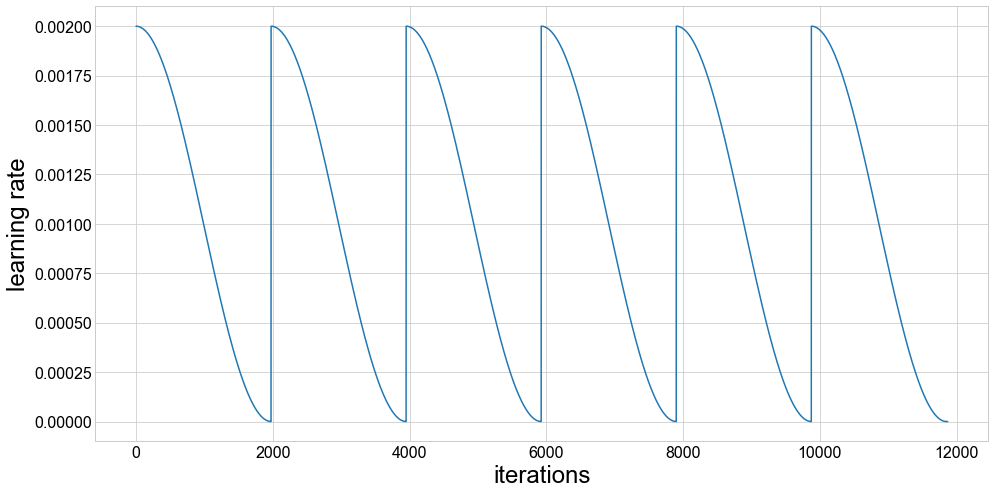

Fold took 95.489s


______________________________________
Training finished
Cross-validation took 1130.672s 


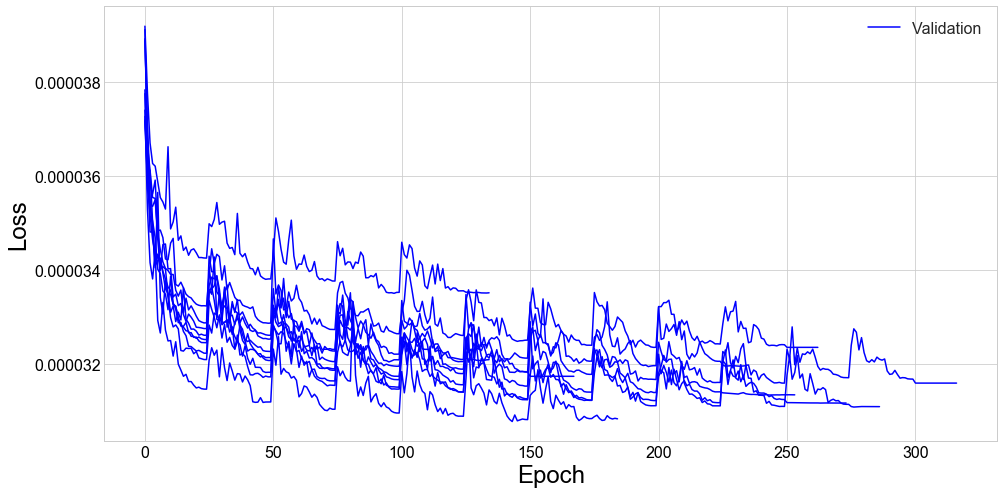

Mean loss = 3.18e-05 +- 2e-07
Mean wAUC = 0.0635 +- 0.001
Mean AUC = 0.099 +- 0.001
Mean AMS = 3.88 +- 0.08
Mean cut = 0.96 +- 0.005
______________________________________



<Figure size 432x288 with 0 Axes>

In [9]:
results, histories, cycle_losses = fold_train_model(train_fy, n_models,
                                                    model_gen_params=model_gen_params,
                                                    train_params=train_params, train_on_weights=True,
                                                    use_callbacks=use_callbacks, ams_args=ams_args,
                                                    max_epochs=max_epochs, patience=patience,
                                                    verbose=1, plots=plots)

## Construct ensemble

In [10]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)
with open('train_weights/cycle_file.pkl', 'rb') as fin:   
    cycle_losses = pickle.load(fin)

In [30]:
import warnings
from hepml_tools.general.ensemble_functions import *

def assemble_ensemble(results, size, metric='loss', weighting='reciprocal',
                      cycle_losses=None, n_cycles=None, load_cycles_only=False, patience=2,
                      compile_args=None, mva='NN', load_mode='model',
                      location='train_weights/', verbose=True):
    if (cycle_losses is not None and n_cycles is None) or (cycle_losses is None and n_cycles is not None):
        warnings.warn("Warning: cycle ensembles requested, but not enough information passed")
        return None, None
    if cycle_losses is not None and n_cycles is not None and metric is not 'loss':
        warnings.warn("Warning: Setting ensemble metric to loss")
        metric = 'loss'
    if cycle_losses is not None and n_cycles is not None and weighting is not 'uniform':
        warnings.warn("Warning: Setting model weighting to uniform")
        weighting = 'uniform'
    
    ensemble = []
    weights = []
    
    if verbose:
        print("Choosing ensemble by", metric)
    dtype = [('model', int), ('result', float)]
    values = np.sort(np.array([(i, result[metric]) for i, result in enumerate(results)], dtype=dtype),
                     order=['result'])
    
    for i in range(min([size, len(results)])):
        if not (load_cycles_only and n_cycles):
            ensemble.append(load_trained_model(values[i]['model'], compile_args, mva, load_mode, location + 'train_'))
            weights.append(get_weights(values[i]['result'], metric, weighting))
        
            if verbose:
                print("Model", i, "is", values[i]['model'], "with", metric, "=", values[i]['result'])
        
        if n_cycles:
            end_cycle = len(cycle_losses[values[i]['model']])-patience
            if load_cycles_only:
                end_cycle += 1
            
            for n, c in enumerate(range(end_cycle, max(0, end_cycle-n_cycles), -1)):
                ensemble.append(load_trained_model(c, compile_args, mva, load_mode, location + f'{values[i]["model"]}_cycle_'))
                weights.append((n+1)**-0)
            
                if verbose:
                    print("Model", i, "cycle", c, "has", metric, "=", cycle_losses[values[i]['model']][c], 'and weight', weights[-1])
        
    weights = np.array(weights)
    weights = weights / weights.sum()  # normalise weights
    return ensemble, weights

In [ ]:
ensemble, weights = assemble_ensemble(results, 1, cycle_losses=cycle_losses, n_cycles=1, load_cycles_only=True)

In [33]:
def test_ensemble(size, rot_mult, n_cycles):
    ensemble, weights = assemble_ensemble(results, size, cycle_losses=cycle_losses, n_cycles=n_cycles, load_cycles_only=False, weighting='uniform')
    #val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))
    val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), rot_mult=rot_mult, reflect_y=True, reflect_z=True)
    fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=0)
    val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')
    ams, cut = ams_scan_slow(val_df_tta, br=10, w_factor=250000/50000)
    print(size, rot_mult, n_cycles, ams, cut)

In [34]:
%%capture --no-stdout
size = 10
rot_mult = 2
for n_cycles in [1,2,3,4]:
    print('__________________________________')
    test_ensemble(size, rot_mult, n_cycles)
    print('__________________________________\n')

__________________________________
Choosing ensemble by loss
Model 0 is 6 with loss = 3.07736205526453e-05
Model 0 cycle 5 has loss = 3.088628143523238e-05 and weight 1
Model 1 is 4 with loss = 3.1082044241568774e-05
Model 1 cycle 9 has loss = 3.110775052816369e-05 and weight 1
Model 2 is 5 with loss = 3.11669143527979e-05
Model 2 cycle 8 has loss = 3.1219236861215903e-05 and weight 1
Model 3 is 3 with loss = 3.133832285317895e-05
Model 3 cycle 7 has loss = 3.1399507327224124e-05 and weight 1
Model 4 is 8 with loss = 3.15922485126066e-05
Model 4 cycle 10 has loss = 3.1592248773085884e-05 and weight 1
Model 5 is 9 with loss = 3.1737014809405714e-05
Model 5 cycle 4 has loss = 3.173701493310317e-05 and weight 1
Model 6 is 7 with loss = 3.1943884662149576e-05
Model 6 cycle 7 has loss = 3.206031610569205e-05 and weight 1
Model 7 is 2 with loss = 3.204300924157906e-05
Model 7 cycle 3 has loss = 3.227430592152636e-05 and weight 1
Model 8 is 1 with loss = 3.2353540768963287e-05
Model 8 cycle 8

KeyboardInterrupt: 

In [26]:
%%capture --no-stdout
size = 1
rot_mult = 2
for n_cycles in [1,2,3,4]:
    print('__________________________________')
    test_ensemble(size, rot_mult, n_cycles)
    print('__________________________________\n')

__________________________________
Choosing ensemble by loss
Model 0 cycle 6 has loss = 3.081463519120007e-05 and weight 1.0
50000 candidates loaded
1 2 1 3.8014197710170063 0.9599164
__________________________________

__________________________________
Choosing ensemble by loss
Model 0 cycle 6 has loss = 3.081463519120007e-05 and weight 1.0
Model 0 cycle 5 has loss = 3.088628143523238e-05 and weight 0.5
50000 candidates loaded
1 2 2 3.7897838769822756 0.96167016
__________________________________

__________________________________
Choosing ensemble by loss
Model 0 cycle 6 has loss = 3.081463519120007e-05 and weight 1.0
Model 0 cycle 5 has loss = 3.088628143523238e-05 and weight 0.5
Model 0 cycle 4 has loss = 3.0954960103554184e-05 and weight 0.3333333333333333
50000 candidates loaded
1 2 3 3.857214599638147 0.96280986
__________________________________

__________________________________
Choosing ensemble by loss
Model 0 cycle 6 has loss = 3.081463519120007e-05 and weight 1.0
Model 

In [29]:
%%capture --no-stdout
size = 1
rot_mult = 2
for n_cycles in [1,2,3,4]:
    print('__________________________________')
    test_ensemble(size, rot_mult, n_cycles)
    print('__________________________________\n')

__________________________________
Choosing ensemble by loss
Model 0 cycle 6 has loss = 3.081463519120007e-05 and weight 1.0
50000 candidates loaded
1 2 1 3.8014197710170063 0.9599164
__________________________________

__________________________________
Choosing ensemble by loss
Model 0 cycle 6 has loss = 3.081463519120007e-05 and weight 1.0
Model 0 cycle 5 has loss = 3.088628143523238e-05 and weight 0.25
50000 candidates loaded
1 2 2 3.784640867105447 0.96217847
__________________________________

__________________________________
Choosing ensemble by loss
Model 0 cycle 6 has loss = 3.081463519120007e-05 and weight 1.0
Model 0 cycle 5 has loss = 3.088628143523238e-05 and weight 0.25
Model 0 cycle 4 has loss = 3.0954960103554184e-05 and weight 0.1111111111111111
50000 candidates loaded
1 2 3 3.814884443562534 0.96329856
__________________________________

__________________________________
Choosing ensemble by loss
Model 0 cycle 6 has loss = 3.081463519120007e-05 and weight 1.0
Model

## Response on validation data without TTA

In [ ]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [ ]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

In [ ]:
val_df = convert_to_df(val_fy.source)

In [ ]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

In [ ]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

In [ ]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

## Response on validation data with TTA

In [ ]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), rot_mult=3, random_rot=True)

In [ ]:
fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

In [ ]:
val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')

In [ ]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class),
                                                           roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class, sample_weight=val_df_tta.gen_weight)))

In [ ]:
%%time
cut_kde_tta = kde_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

In [ ]:
%%time
cut_mean_tta = mean_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [ ]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [ ]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

In [ ]:
score_test_data(test_fy.source, cut_kde)

In [ ]:
score_test_data(test_fy.source, cut_mean)

# Test scoring - With TTA

In [ ]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"), rot_mult=3, random_rot=True)

In [ ]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

In [ ]:
score_test_data(test_fy.source, cut_kde_tta, pred_name='pred_TTA')

In [ ]:
score_test_data(test_fy.source, cut_mean_tta, pred_name='pred_TTA')

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)